# HW9. Регрессионный анализ.
#### Ильичёв А.С., 693

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import pandas as pd
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline


%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 5) 

## Задача 4.

In [271]:
df = pd.read_csv('parkinsons_updrs_train.csv')
df.head()


,subject#,age,sex,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,...,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,motor_UPDRS_train,total_UPDRS_train,id
0,1,72,0,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,...,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,28.199,34.398,1
1,1,72,0,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,...,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,NaN,NaN,2
2,1,72,0,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,...,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,28.695,35.389,3
3,1,72,0,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,...,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,28.905,35.810,4
4,1,72,0,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,...,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,29.187,36.375,5


In [272]:
answers = df.copy()

In [4]:
train_df = df[df['motor_UPDRS_train'].notnull()]
len(train_df)

4394

In [13]:
test_df = df[~df['motor_UPDRS_train'].notnull()]
len(test_df)

1481

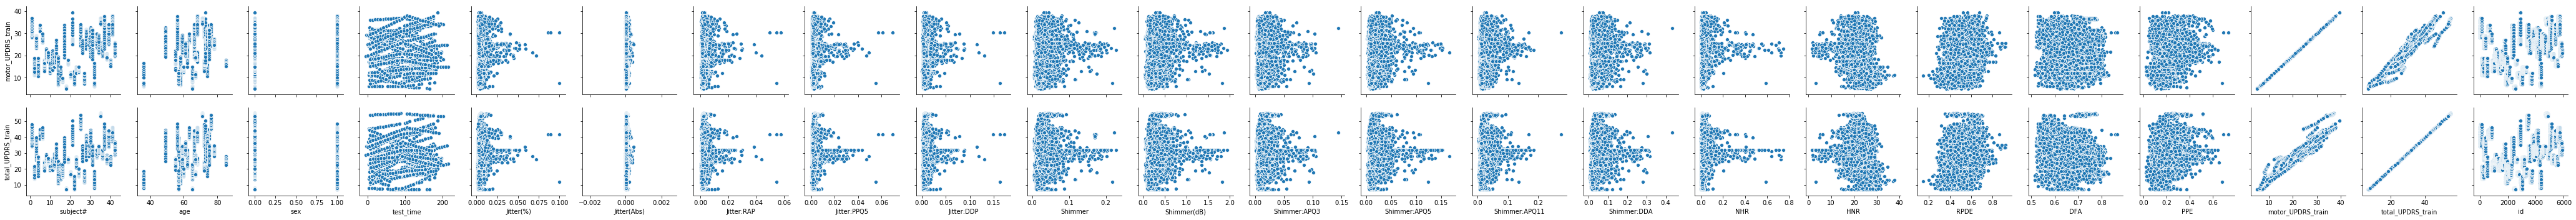

In [15]:
sns.pairplot(train_df, x_vars=train_df.columns, y_vars=['motor_UPDRS_train', 'total_UPDRS_train'])

Видим, что данные кластеризуются по признаку subject. Будем применять метод пошаговой регрессии, отдельно для каждого таргета и для каждого subject.

Сначала обучим регрессию на всех признаках, чтобы применять критерий Фишера.

In [283]:
targets = ['motor_UPDRS_train', 'total_UPDRS_train']

In [284]:
subjects = df['subject#'].unique()
subjects

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42])

In [285]:
motor_models = dict()
total_models = dict()
train_dfs = dict()
motor_targets = dict()
total_targets = dict()
motor_rss = dict()
total_rss = dict()

for subject in subjects:
    train_dfs[subject] = train_df[train_df['subject#'] == subject].drop(targets, 1).drop('subject#', 1)
    motor_targets[subject] = train_df[train_df['subject#'] == subject][targets[0]]
    total_targets[subject] = train_df[train_df['subject#'] == subject][targets[1]]
    motor_models[subject] = LinearRegression().fit(train_dfs[subject], motor_targets[subject])
    total_models[subject] = LinearRegression().fit(train_dfs[subject], total_targets[subject])
    motor_rss[subject] = np.sum((motor_targets[subject] - motor_models[subject].predict(train_dfs[subject])) ** 2)
    total_rss[subject] = np.sum((total_targets[subject] - total_models[subject].predict(train_dfs[subject])) ** 2)    

In [286]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [287]:
scores = -cross_val_score(base, X_train, y_train, scoring=rmse_scorer, cv=10)
np.mean(scores)

8.231458457071046

In [35]:
k = len(train_df.columns) - 3
k

20

In [226]:
def fisher(rss0, rss, m, n, k=k, forward=True):
    f = (rss0 - rss) / rss * (n - k - 1) / m
#     print(f)
    dist = sts.f
    if forward:
        p = 1 - dist.cdf(x=f, dfn=m, dfd=n - k - 1)
    else: 
        p = dist.cdf(x=f, dfn=m, dfd=n - k - 1)

    return p

Метод пошаговой регресии:

In [278]:
class StepRegression:
    def __init__(self, subject, models_dict=motor_models, targets_dict=motor_targets,
                 rss_dict=motor_rss, pin=0.1, pout=0.15):
        self.df = train_dfs[subject]
        self.columns = self.df.columns
        self.model = LinearRegression()
        self.targets_dict = targets_dict
        self.models_dict = models_dict
        self.rss_dict = rss_dict
        self.pin = pin
        self.pout = pout
        self.subject = subject
        self.chosen = []
        
    def step_forward(self):
        targets_dict = self.targets_dict
        models_dict = self.models_dict
        subject = self.subject
        not_chosen = list(set(self.columns) - set(self.chosen))
        pvalues = []
        if len(self.chosen) == 0:
            rss = np.sum((targets_dict[subject] - np.mean(targets_dict[subject])) ** 2)
        else:
            train_df = self.df[self.chosen]
            self.model.fit(train_df, targets_dict[subject])
            rss = np.sum((targets_dict[subject] - self.model.predict(train_df)) ** 2)
        for i, column in enumerate(not_chosen):
            columns = self.chosen + [column]
            train_df = self.df[columns]
            self.model.fit(train_df, targets_dict[subject])
            rss0 = np.sum((targets_dict[subject] - self.model.predict(train_df)) ** 2)
            k = len(columns)
            p = fisher(rss, rss0, m=k, n = len(train_df), k=k + 1)
            pvalues.append(p)
            
#             print(rss, rss0, column)
#             print('column ', column, 'p ', p)
        pairs = list(enumerate(pvalues))
        pairs.sort(key = lambda a : a[1])
        if len(pairs) > 0:
#             print(pvalues)
#             print('min pin', pairs[0][1])
            if pairs[0][1] < self.pin:
                self.chosen.append(not_chosen[pairs[0][0]])
            else:
                return True
        return False
        
    def step_backward(self):
        targets_dict = self.targets_dict
        models_dict = self.models_dict
        subject = self.subject
        not_chosen = list(set(self.columns) - set(self.chosen))
        pvalues = []
#         print(self.chosen)
        train_df = self.df[self.chosen]
        self.model.fit(train_df, targets_dict[subject])
        rss = np.sum((targets_dict[subject] - self.model.predict(train_df)) ** 2)
#         print(rss)
        for i, column in enumerate(self.chosen):
            columns = list(set(self.chosen) - set([column]))
#             print(columns)
            if len(columns) == 0:
                break
            train_df = self.df[columns]
            self.model.fit(train_df, targets_dict[subject])
            rss0 = np.sum((targets_dict[subject] - self.model.predict(train_df)) ** 2)
            k = len(columns)
#             print(k)
            p = fisher(rss, rss0, m=k + 1, n = len(train_df), k=k + 2, forward=False)
            pvalues.append(p)
#             print(rss, rss0)
        pairs = list(enumerate(pvalues))
        pairs.sort(key = lambda a : a[1], reverse=True)
        if len(pairs) > 0:
#             print(pvalues)
#             print('max pout', pairs[0][1])
            if pairs[0][1] > self.pout:
#                 print(self.chosen[pairs[0][0]])
                self.chosen = list(set(self.chosen) - set([self.chosen[pairs[0][0]]]))
        
    def run(self):
        for i in range(len(self.df.columns) - 1):
            if self.step_forward():
                break
            self.step_backward()
        return self.chosen


Отберем признаки и сразу запустим предсказание.

In [292]:
pd.options.mode.chained_assignment = None 
for subject in subjects:
    step_motor = StepRegression(subject)
    cols = step_motor.run()
    if len(cols) == 0:
        answers.loc[answers['subject#'] == subject, 'motor_UPDRS_train'] = np.mean(
            train_df[train_df['subject#'] == subject]['motor_UPDRS_train'])
    else:
        train_dfs_motor = train_df[train_df['subject#'] == subject][cols]
        model = LinearRegression().fit(train_dfs_motor, motor_targets[subject])
        answers.loc[answers['subject#'] == subject, 'motor_UPDRS_train'] = model.predict(
            answers[answers['subject#'] == subject][cols])
    
    step_total = StepRegression(subject, models_dict=total_models, targets_dict=total_targets, rss_dict=total_rss)
    cols_total = step_total.run()
    if len(cols_total) == 0:
        answers.loc[answers['subject#'] == subject, 'total_UPDRS_train'] = np.mean(
            train_df[train_df['subject#'] == subject]['total_UPDRS_train'])
    else:
        train_dfs_total = train_df[train_df['subject#'] == subject][cols_total]
        model = LinearRegression().fit(train_dfs_total, total_targets[subject])
        answers.loc[answers['subject#'] == subject, 'total_UPDRS_train'] = model.predict(
                answers[answers['subject#'] == subject][cols_total])
    print('subject: ', subject, 'motor feat: ', cols, 'total feat: ', cols_total)
   

subject:  1 motor feat:  ['test_time', 'DFA', 'id'] total feat:  ['test_time', 'DFA', 'id']
subject:  2 motor feat:  ['test_time', 'HNR'] total feat:  ['test_time', 'HNR']
subject:  3 motor feat:  ['test_time', 'DFA', 'RPDE'] total feat:  ['test_time', 'DFA', 'RPDE']
subject:  4 motor feat:  ['test_time', 'DFA'] total feat:  ['test_time', 'DFA']
subject:  5 motor feat:  ['test_time', 'id', 'DFA'] total feat:  ['test_time', 'id', 'DFA']
subject:  6 motor feat:  ['test_time', 'HNR', 'Jitter:PPQ5', 'NHR'] total feat:  ['test_time', 'HNR', 'Jitter:PPQ5', 'NHR']
subject:  7 motor feat:  ['test_time'] total feat:  ['test_time']
subject:  8 motor feat:  ['test_time', 'PPE'] total feat:  ['test_time', 'PPE']
subject:  9 motor feat:  ['test_time'] total feat:  ['test_time']
subject:  10 motor feat:  ['test_time'] total feat:  ['test_time']
subject:  11 motor feat:  ['test_time', 'HNR'] total feat:  ['HNR']
subject:  12 motor feat:  ['test_time', 'DFA', 'id'] total feat:  ['test_time', 'DFA', 'i

In [299]:
answers['motor_UPDRS'] = answers['motor_UPDRS_train']
answers['total_UPDRS'] = answers['total_UPDRS_train']

submission = answers[['motor_UPDRS', 'total_UPDRS', 'id']]
submission.head()

,motor_UPDRS,total_UPDRS,id
0,27.679006,34.094885,1
1,27.916755,34.584700,2
2,28.473754,35.260394,3
3,28.502766,35.575579,4
4,29.078566,36.311236,5


In [300]:
submission.to_csv('sub9-4.csv', index=False)

(тут все очень некрасиво оформлено, но дедлайн поджал)